# K-means analysis

We used k-means to cluster our 58 seed regions. This notebook will rely on custom functions, but they are essentially wrapped around Scikit-learn's KMeans function. It is important to note that k-means is not guaranteed to find the optimal solution and may fall into local maxima. As recommended by (Nanetti et al., 2009), we ran k-means 256 times to find the most stable solution. Since this many iterations takes a few hours to calculate, the k-means data will be available in this repository. However, this notebook will demonstrate how the custom function works using just 3 iterations.

# Example

In [1]:
#Prep work
import pandas as pd
import pickle as pkl
import proj_utils as putils
from k_means import kmeansUtils as kutils

with open(r'./pData.pkl', 'rb') as file:
    project_data = pkl.load(file)

C:\Users\ixa080020\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data
Now we'll load in the data. Here, we'll demonstrate clustering based on similarity to known intrinsic networks (default mode, salience, etc.), which we calculated using the Jaccard similarity index. Given two sets X and Y, the Jaccard index is the intersection X and Y divided by their union,

$$J(X,Y) = \frac{|X \cap Y|}{|X \cup Y|}$$ 

In this case, our Xs are second-level t-test masks for each cingulate seed, and our Ys are masks corresponding to eight intrinsic networks calculated by the Human Connectome Project group using the CONN Toolbox. Since these measures take a long time to calculate, we have made the results directly available in this repository. 

In [2]:
seed_to_networks = pd.read_csv(r"./notebook_data/jaccard_seed_to_ica_networks.csv", index_col=0)
seed_list = list(seed_to_networks.index) #need seed names for later
seed_to_networks.head() #Only show first 5 rows

,DMN,Sensorimotor,Salience,Visual,Language,DorsalAttention,FPN,Cerebellar
pMCC_i3_R,0.000134,0.000095,0.000034,0.000053,0.000285,0.000008,0.000105,0.000005
dPCC_i1_R,0.002008,0.000187,0.000029,0.000190,0.000040,0.000206,0.005267,0.000145
dPCC_i2_R,0.003136,0.000011,0.000000,0.000069,0.000016,0.000013,0.002927,0.000066
dPCC_i3_R,0.001594,0.000000,0.000000,0.000158,0.000063,0.000000,0.000003,0.000005
vPCC_i1_R,0.005963,0.000983,0.000000,0.000651,0.000055,0.000121,0.000184,0.000047


Next, we will turn this data into a cross-correlation matrix. This will allow us to see the structure of interrelationships within our data. Refer to (Torta & Cauda, 2011, Gorman et al., 1983) for more information.

In [3]:
prep_dataframe = seed_to_networks.T #Transposing matrix
seed_network_corr = prep_dataframe.corr()
seed_network_corr.head() #Show only first 5 rows

,pMCC_i3_R,dPCC_i1_R,dPCC_i2_R,dPCC_i3_R,vPCC_i1_R,RSC_R,pMCC_i3_L,dPCC_i1_L,dPCC_i2_L,dPCC_i3_L,...,aMCC_s1_R,pgACC_s3_R,pgACC_s2_R,pMCC_s2_L,pMCC_s1_L,aMCC_s3_L,aMCC_s2_L,aMCC_s1_L,pgACC_s3_L,pgACC_s2_L
pMCC_i3_R,1.000000,0.120105,0.200668,0.216593,0.188461,-0.081727,0.338644,0.056950,0.264001,0.451367,...,-0.221943,0.112619,0.405760,-0.008469,-0.187259,-0.138654,-0.076045,-0.102483,0.459042,0.854841
dPCC_i1_R,0.120105,1.000000,0.860975,0.196793,0.198453,-0.103729,0.699903,0.985094,0.979993,0.753652,...,0.200464,0.769902,0.788832,-0.351499,-0.361240,-0.421838,0.104524,0.225469,0.650992,0.386703
dPCC_i2_R,0.200668,0.860975,1.000000,0.665707,0.658817,-0.016521,0.387834,0.774705,0.914848,0.939563,...,0.043120,0.662179,0.945509,-0.418659,-0.433280,-0.498187,-0.045629,0.075007,0.485404,0.536438
dPCC_i3_R,0.216593,0.196793,0.665707,1.000000,0.985429,0.206343,-0.234843,0.053049,0.331345,0.721937,...,-0.247620,0.116105,0.649557,-0.258893,-0.305586,-0.360588,-0.288873,-0.232359,-0.050525,0.450907
vPCC_i1_R,0.188461,0.198453,0.658817,0.985429,1.000000,0.238241,-0.262828,0.049640,0.316506,0.688715,...,-0.285357,0.072735,0.617931,-0.113185,-0.158266,-0.255805,-0.331870,-0.279236,-0.114793,0.376887


## Clustering
Next, we'll demonstrate the custom kmeans code and show our rationale for choosing the k solution.

In [4]:
data = seed_network_corr.values
k = data.shape[1] - 1 #maximum number of clusters to test
network_kmeans, network_silScores = kutils.kmeans(data, k, niters=3)

Estimated runtime: 2.66 minutes
Iteration: 1 out of 3...
Iteration: 2 out of 3...
Iteration: 3 out of 3...
Calculation time: 1.97 minutes


## Silhouette score analysis

Silhouette scores range from -1 to 1 and describe how well observations fit into their assigned clusters. The average silhouette score across observations is usually taken as a measure of the quality of the clustering solution. We can determine which k to use for our analysis by determining which k has highest and most consistent silhouette score across iterations.

<Figure size 640x480 with 0 Axes>

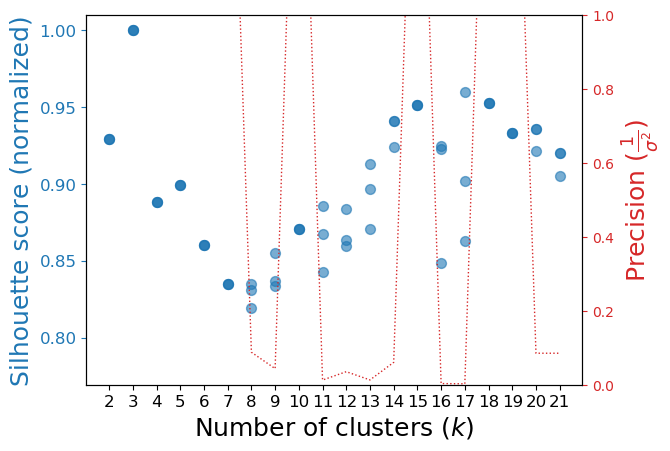

In [5]:
best_k = kutils.bestSilScores(network_silScores, 20)

Since the highest and most consistent silhouette score is achieved when k = 3, that is the solution we will use.

# Clustering using voxelwise similarity to resting state networks

Now we will plot the results of running k-means 256 times, using k=3.

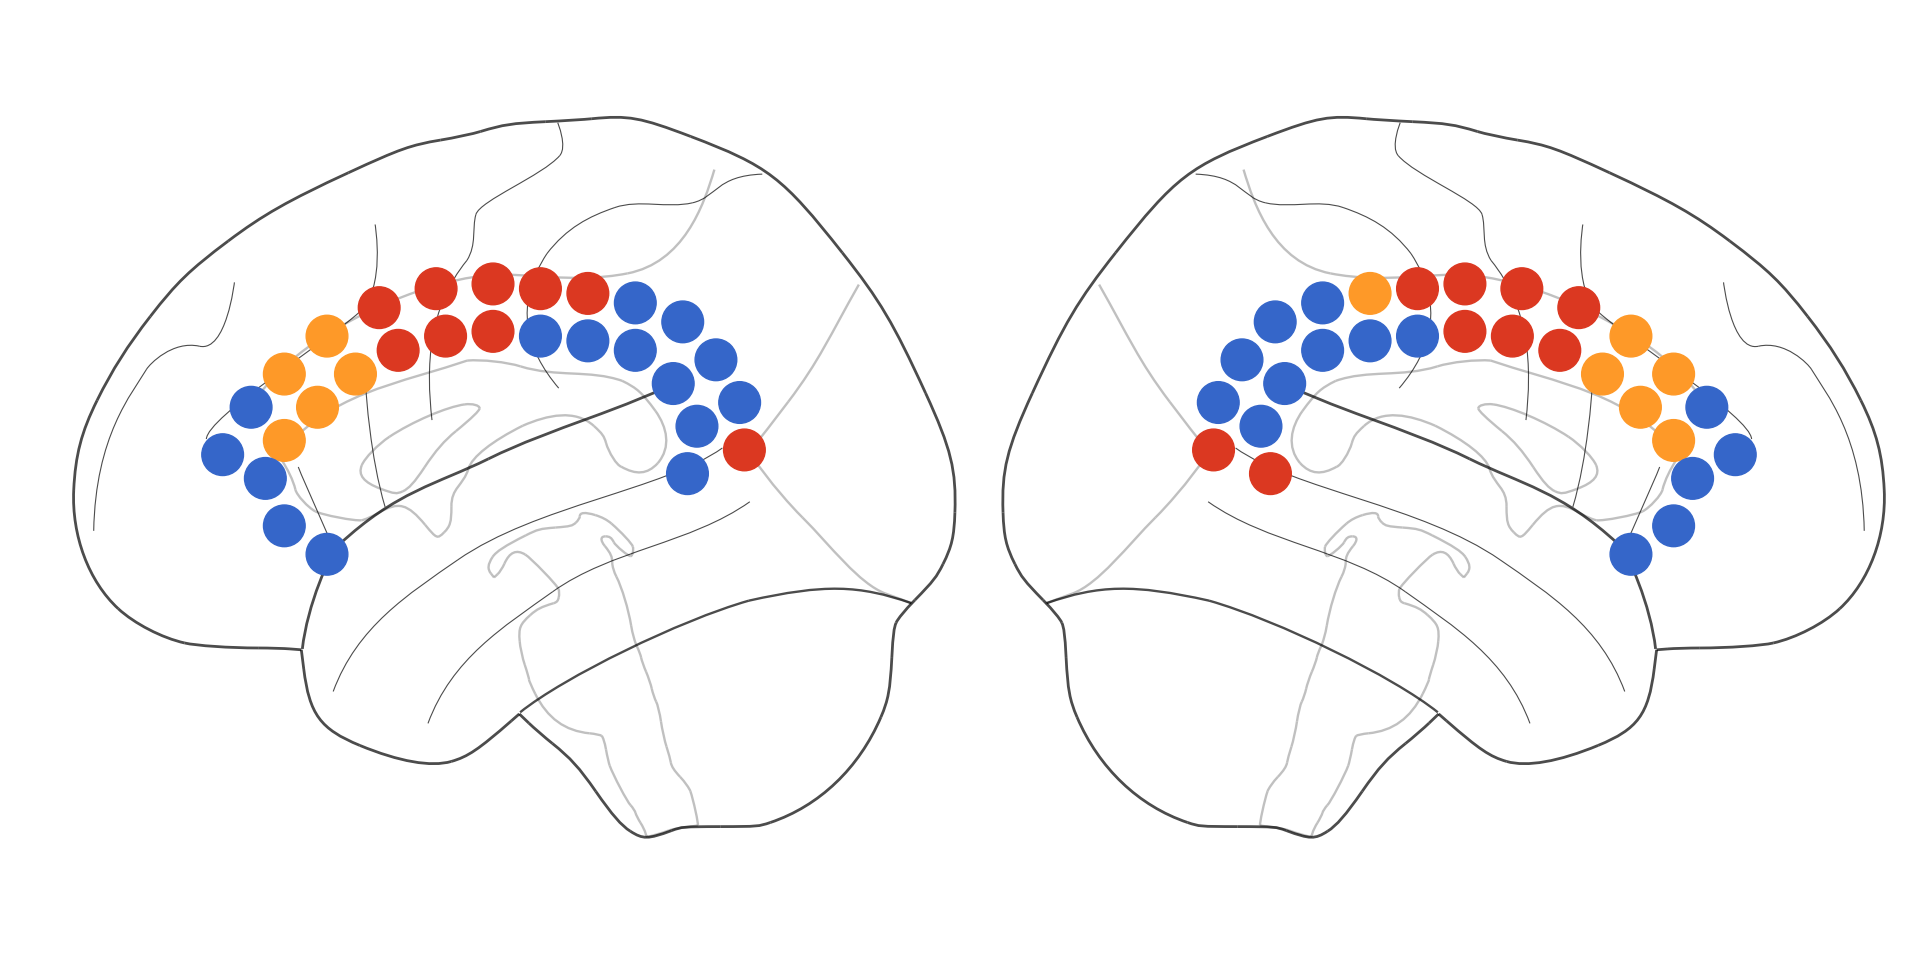

In [7]:
with open(r"./notebook_data/seed_networks_results.pkl", 'rb') as file:
    seed_networks_256 = pkl.load(file)
seed_networks_km_data = seed_networks_256['km'] #Getting k-means results

network_consistency_256 = kutils.bestSolution(seed_networks_km_data, best_k, seed_list)
colors = putils.node_color_generator(project_data['catColors'], network_consistency_256.values[:, 0])
putils.plotBrains(project_data['coordsMNI'], colors)

# Clustering using functional preference profiles
The previous clustering solutions were based on the similarity of the seeds' whole brain connectivity to known intrinsic networks. It is also possible to cluster the seeds based on their meta-analytic functional preference profiles. Here, we've used code from de la Vega et al. (2016) (https://github.com/adelavega/neurosynth-mfc) to generate these profiles for each seed.

In [8]:
fpp_df = pd.read_csv(r"./notebook_data/seed_functional_profiles.csv", index_col=0)
fpp_df.head() #Show only first 5 rows

,stress,vision-shape,episodic memory,object recognition,motor,attention,gaze,learning,social,math,...,LTM,action,reasoning,fear,gustation,WM,motion,pain,sensory,spatial processing
pMCC_i3_R,0.097614,-0.427983,0.389894,-0.501955,0.169419,-0.200513,-0.392324,-0.275052,0.119152,-0.362441,...,0.158599,-0.451182,0.175284,0.340726,0.521716,-0.060448,-1.255627,0.789401,-0.479369,0.125869
dPCC_i1_R,0.204051,-0.904441,0.601274,-0.132889,0.376341,-0.255816,-1.099917,0.100780,0.144877,-0.100780,...,0.416603,-0.660331,-0.160168,0.445179,0.522473,-0.369649,-1.085482,0.688204,-0.357382,-0.463674
dPCC_i2_R,0.124474,-0.874479,-0.274717,-0.378629,0.667649,-0.273019,-0.174235,0.294589,-0.199177,-0.296727,...,0.163053,0.034524,-0.158240,0.678929,0.582419,-0.076024,-0.626899,1.068412,-0.289355,-0.376811
dPCC_i3_R,0.299476,-0.827625,-0.500203,-0.234480,0.700201,-0.336315,-0.453451,0.197911,-0.260048,-0.454853,...,0.092625,0.044118,-0.229124,0.726646,-0.469733,-0.292959,-0.928406,1.013884,0.053605,-0.687693
vPCC_i1_R,0.085615,-0.472559,-0.086681,-0.462770,0.338173,-0.009466,0.022174,0.004331,-0.014318,0.190407,...,0.050438,0.188644,-0.346145,1.227999,0.013255,-0.163382,-0.969537,1.232275,-0.220283,-0.619727


The columns of this data show various functional topics derived from the Neurosynth database, which houses fMRI-activation related data from over 14,000 studies (as of January 2019). Using this data, we calculated another cross-correlation matrix, resulting in a symmetric 58 x 58 matrix on which to run k-means clustering. Our silhouette score analysis also returned k = 3 as the most stable solution, so we'll plot that solution on the brain.

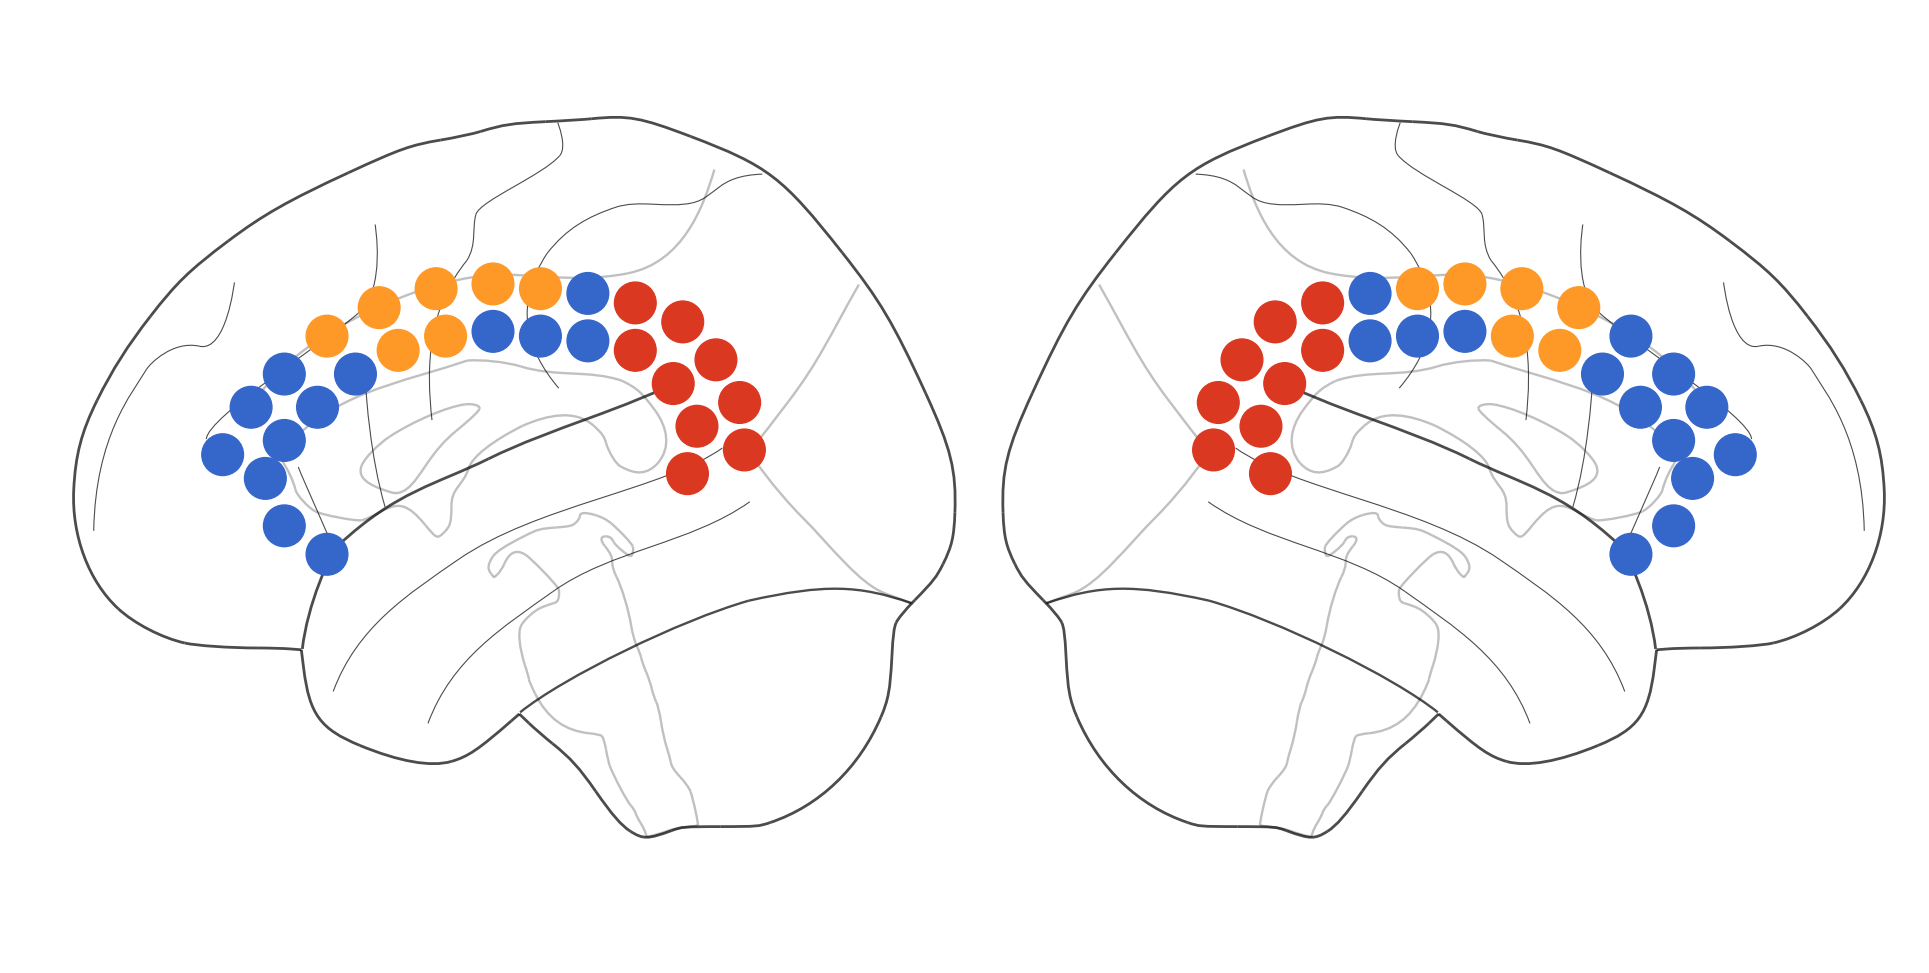

In [9]:
with open(r"./notebook_data/seed_fpp_results.pkl", 'rb') as file:
    seed_fpp_256 = pkl.load(file)
seed_fpp_km_data = seed_fpp_256['km'] #Getting k-means results

best_k = 3
fpp_consistency_256 = kutils.bestSolution(seed_fpp_km_data, best_k, seed_list)

colors = putils.node_color_generator(project_data['catColors'], fpp_consistency_256.values[:, 0])
putils.plotBrains(project_data['coordsMNI'], colors)

# Clustering using both networks and functions simultaneously
Finally, we combined the two datasets into a single 58 x 116 matrix and re-ran k-means. For this matrix, the silhouette score analysis again suggested that k = 3 was the most stable solution.

<Figure size 640x480 with 0 Axes>

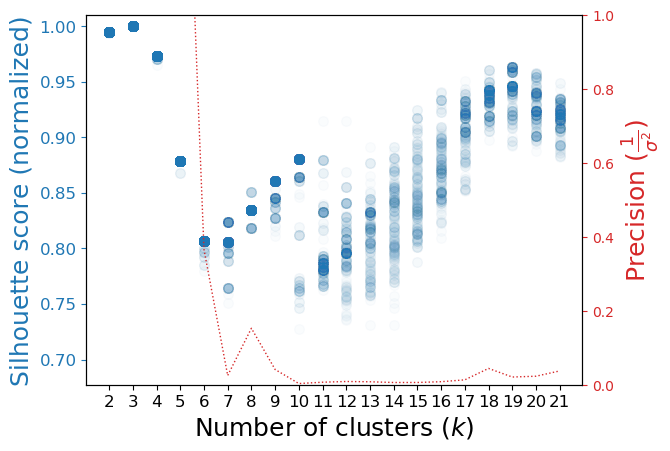

In [10]:
with open(r"./notebook_data/seed_combined_results.pkl", 'rb') as file:
    seed_combined_256 = pkl.load(file)
seed_combined_sil_scores = seed_combined_256['sil']

best_k = kutils.bestSilScores(seed_combined_sil_scores, 20)

Now let's see how the seeds were clustered when the two datasets were combined.

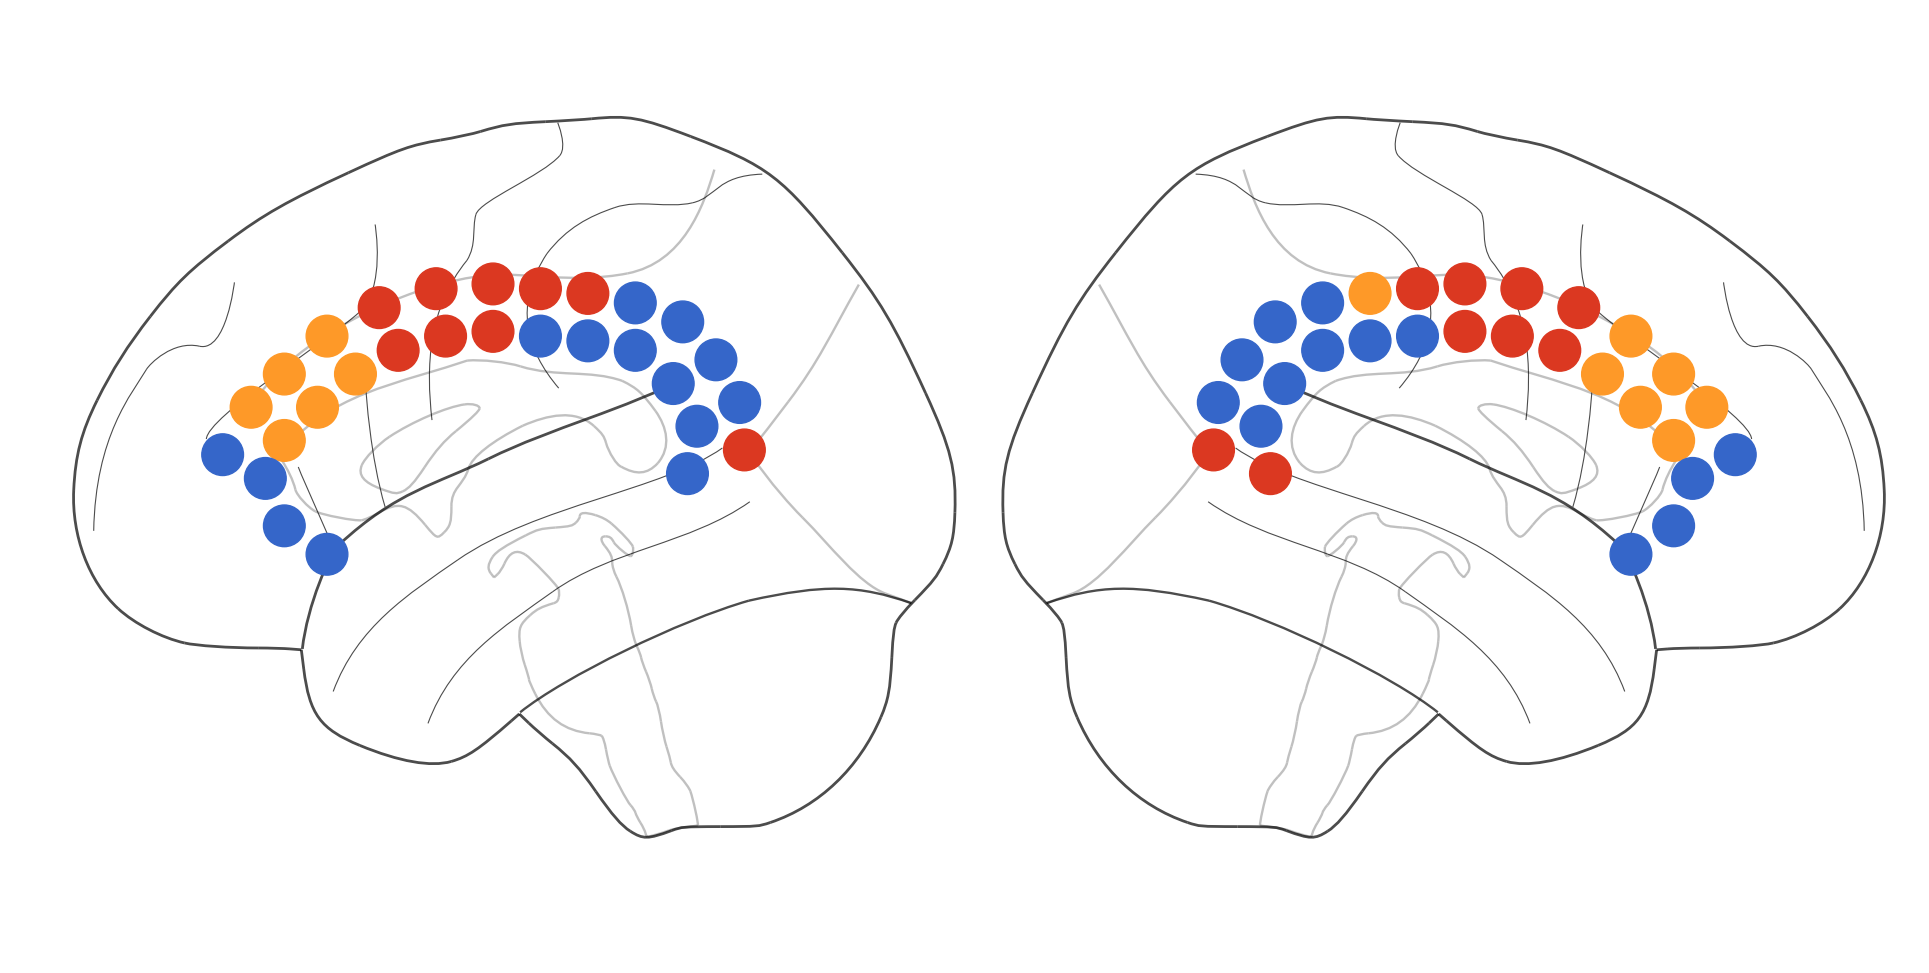

In [11]:
seed_combined_km_data = seed_combined_256['km'] #Getting k-means results

best_k = 3
combined_consistency_256 = kutils.bestSolution(seed_combined_km_data, best_k, seed_list)

colors = putils.node_color_generator(project_data['catColors'], combined_consistency_256.values[:, 0])
putils.plotBrains(project_data['coordsMNI'], colors)